# CS23MTECH14006 - MANAN PATEL
# ASSIGNMENT 3

### **Q1)**  

**Self-Attention for Object Recognition with CNNs**: Implement a sample CNN with one or more self-attention layer(s) for performing object recognition over CIFAR-10 dataset. You have to implement the self-attention layer yourself and use it in the forward function defined by you. All other layers (fully connected, nonlinearity, conv layer, etc.) can be bulit-in implementations. The network can be a simpler one (e.g., it may have 1x Conv, 4x [Conv followed by SA], 1x Conv, and 1x GAP). Please refer to the reading material provided here or any other similar one.

In [1]:
# Import necessary modules and dependencies
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.optim as optim

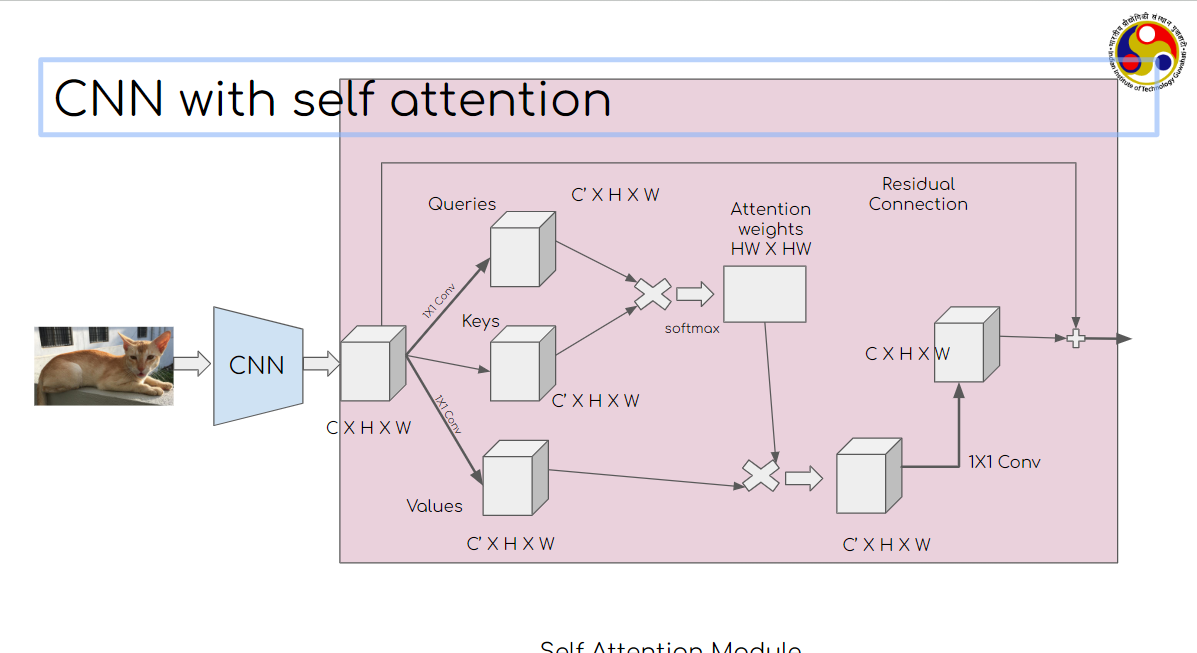

In [2]:
# Define a self-attention mechanism layer
class SelfAttention(nn.Module):

    def __init__(self, inDim):

        super(SelfAttention, self).__init__()

        # Define 1x1 convolutional layers for query, key, and value
        self.Q = nn.Conv2d(in_channels=inDim, out_channels=inDim//8, kernel_size=1)
        self.K = nn.Conv2d(in_channels=inDim, out_channels=inDim//8, kernel_size=1)
        self.V = nn.Conv2d(in_channels=inDim, out_channels=inDim, kernel_size=1)

        # Initialize a learnable parameter for scaling self-attended features
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, input):

        batchSize, channels, width, height = input.size()

        # Project input to query, key
        Q = self.Q(input).view(batchSize, -1, width*height).permute(0, 2, 1)
        K = self.K(input).view(batchSize, -1, width*height)

        # Compute attention scores
        attention = F.softmax(torch.bmm(Q, K), dim=-1)

        # Project input to value space
        V = self.V(input).view(batchSize, -1, width*height)

        # Compute self-attended features
        Z = torch.bmm(V, attention.permute(0, 2, 1))

        Z = Z.view(batchSize, channels, width, height)

        # Apply residual connection
        Z = self.gamma * Z + input
        return Z

In [3]:
# Define the CNN model with self-attention
class CNNWithSelfAttention(nn.Module):
    def __init__(self):
        super(CNNWithSelfAttention, self).__init__()

        # Define convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 10, kernel_size=3, padding=1)

        # Define self-attention layers
        self.sa1 = SelfAttention(32)
        self.sa2 = SelfAttention(64)
        self.sa3 = SelfAttention(128)

        # Define global average pooling layer
        self.pooling = nn.AdaptiveAvgPool2d((1, 1))


    def forward(self, input):

        # Convolutional layers with ReLU activation

        input = F.relu(self.conv1(input))
        input = self.sa1(input)

        input = F.relu(self.conv2(input))
        input = self.sa2(input)

        input = F.relu(self.conv3(input))
        input = self.sa3(input)

        input = F.relu(self.conv4(input))

        input = self.pooling(input)

        input = input.view(-1, 10)

        return input

In [5]:
# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainDataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
testDataset = CIFAR10(root='./data', train=False, download=True, transform=transform)

# Define the batch size
batchSize = 256

# Move the dataset and dataloader to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

trainLoader = DataLoader(trainDataset, batch_size=batchSize, shuffle=True)
testLoader = DataLoader(testDataset, batch_size=batchSize, shuffle=False)

# Instantiate the model, loss function, and optimizer
model = CNNWithSelfAttention().to(device)
lossFunction = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

CNNLossList=[]

# Training loop
maxEpochs = 5
for epoch in range(maxEpochs):
    model.train()
    currentLoss = 0.0
    match = 0
    totalLables = 0

    for i, data in enumerate(trainLoader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = lossFunction(outputs, labels)
        loss.backward()
        optimizer.step()
        currentLoss += loss.item()
    print('Epoch %d, Training Loss: %.4f' % (epoch+1, currentLoss / len(trainLoader)))

    # Evaluate the model on test set
    model.eval()
    match = 0
    totalLabels = 0
    with torch.no_grad():
        for data in testLoader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            totalLabels += labels.size(0)
            match += (predicted == labels).sum().item()

    test_accuracy = 100 * match / totalLabels
    print('Accuracy on test set: %.2f %%' % test_accuracy)
    CNNLossList.append(test_accuracy)



Files already downloaded and verified
Files already downloaded and verified
cuda
Epoch 1, Training Loss: 2.1629
Accuracy on test set: 29.39 %
Epoch 2, Training Loss: 1.7692
Accuracy on test set: 40.90 %
Epoch 3, Training Loss: 1.5034
Accuracy on test set: 48.52 %
Epoch 4, Training Loss: 1.3433
Accuracy on test set: 53.30 %
Epoch 5, Training Loss: 1.2528
Accuracy on test set: 54.29 %


## Q2)

**Object Recognition with Vision Transformer**: Implement and train an Encoder only Trans former (ViT-like) for the above object recognition task. In other words, implement multi-headed self-attention for the image classification (i.e., appending a < class > token to the image patches that are accepted as input tokens). Compare the performance of the two implementations (try to keep the number of parameters to be comparable and use the same amount of training and testing data).

In [11]:
# Import necessary modules and dependencies
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms

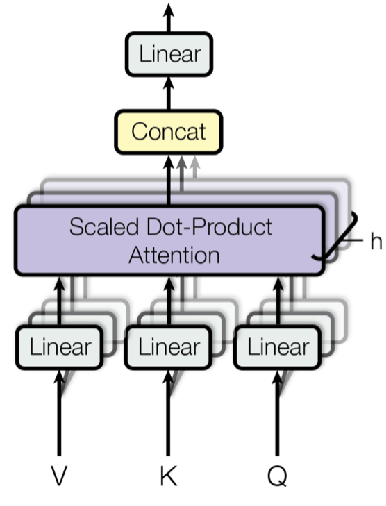

In [12]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hiddenLayerSizeFFN, multiHeads):
        super(MultiHeadAttentionLayer, self).__init__()
        self.hiddenLayerSizeFFN = hiddenLayerSizeFFN  # Dimension of each token
        self.multiHeads = multiHeads  # Number of attention heads

        # Calculate the dimension of each head
        headDim = hiddenLayerSizeFFN // multiHeads

        # Define linear mappings for queries, keys, and values for each head
        self.Q = nn.ModuleList([nn.Linear(hiddenLayerSizeFFN, headDim) for _ in range(self.multiHeads)])
        self.K = nn.ModuleList([nn.Linear(hiddenLayerSizeFFN, headDim) for _ in range(self.multiHeads)])
        self.V = nn.ModuleList([nn.Linear(hiddenLayerSizeFFN, headDim) for _ in range(self.multiHeads)])

        self.headDim = headDim
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, inputs):

        outputs = []

        for sequence in inputs:
            headOutputs = []

            for i in range(self.multiHeads):
                Q = self.Q[i]
                K = self.K[i]
                V = self.V[i]

                # Map the sequence through query, key, and value linear mappings
                q, k, v = Q(sequence), K(sequence), V(sequence)

                attention = self.softmax(q @ k.transpose(0, 1) / (self.headDim ** 0.5))
                headOutputs.append(attention @ v)

            # Concatenate the results from all heads
            outputs.append(torch.cat(headOutputs, dim=-1))

        # Stack the results for all sequences in the batch
        return torch.stack(outputs)

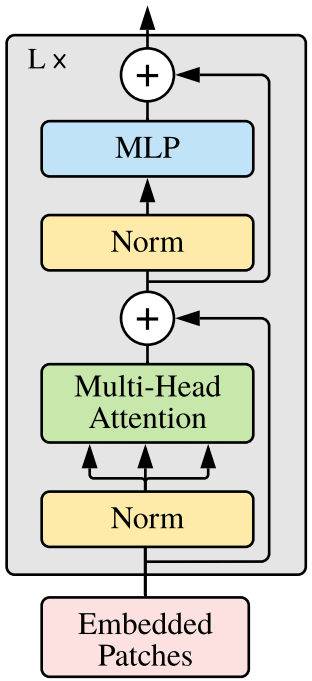

In [13]:
class VITEncoderLayer(nn.Module):

    def __init__(self, hiddenLayerSizeFFN, multiHeads):

        super(VITEncoderLayer, self).__init__()

        self.multiHeadAttention = MultiHeadAttentionLayer(hiddenLayerSizeFFN, multiHeads)

        self.norm1 = nn.LayerNorm(hiddenLayerSizeFFN)
        self.norm2 = nn.LayerNorm(hiddenLayerSizeFFN)

        self.FFN = nn.Sequential(
            nn.Linear(hiddenLayerSizeFFN, hiddenLayerSizeFFN),
            nn.ReLU(),
            nn.Linear(hiddenLayerSizeFFN, hiddenLayerSizeFFN)
        )

    def forward(self, input):

        # Add & Norm
        input = self.norm1(input)

        # Multi-Head Self-Attention
        attentionOutput = self.multiHeadAttention(input)

        # Add & Norm & residual
        input = self.norm2(input + attentionOutput)
        # Feedforward
        ffn = self.FFN(input)

        # Apply residual Block
        return input + ffn

In [14]:
# Vision Transformer Model
class VisionTransformer(nn.Module):

    def __init__(self, patchsize, nPatches, nClasses, hiddenLayerSizeFFN, L, multiHeads):
        super(VisionTransformer, self).__init__()

       # Patch Embedding Layer: Convert image into patches
        self.patchEmbedding = nn.Conv2d(in_channels=3, out_channels=hiddenLayerSizeFFN, kernel_size=patchsize, stride=patchsize)

        # Positional Encoding Layer: learnable positional encoding
        self.positionalEncoding = nn.Parameter(torch.randn(1, nPatches + 1, hiddenLayerSizeFFN))

        # Encoder Layers
        self.L = nn.ModuleList([
            VITEncoderLayer(hiddenLayerSizeFFN, multiHeads)
            for _ in range(L)
        ])

        self.classfication = nn.Linear(hiddenLayerSizeFFN, nClasses)

    def forward(self, input):
        # Patching and Embedding
        input = self.patchEmbedding(input)  # (batch_size, hidden_size, num_patches, num_patches)
        input = input.flatten(2).transpose(1, 2)  # (batch_size, num_patches, hidden_size)

        # Add class token
        batch_size = input.size(0)
        class_token = self.positionalEncoding[:, 0:1, :].expand(batch_size, -1, -1)
        input = torch.cat((class_token, input), dim=1)

        # Transformer Encoder
        for layer in self.L:
            input = layer(input)

        #  Apply Classification
        input = input[:, 0, :]  # Only take the class token
        input = self.classfication(input)

        return input

In [15]:
# Model parameters
imgSize = 32  # Size of input images (assuming CIFAR-10)
patchSize = 4   # Size of each patch
nPatches = (imgSize // patchSize) ** 2

nClasses = 10  # Number of classes in CIFAR-10
hiddenLayerSizeFFN = 64  # Hidden size of the transformer layers
L = 1     # Number of transformer layers
multiHeads = 4      # Number of attention heads


# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

# Dataset and DataLoader
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize inputs
])

# Load CIFAR-10 dataset
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create DataLoader for training and testing datasets
trainLoader = DataLoader(train_dataset, batch_size=128, shuffle=True)
testLoader = DataLoader(test_dataset, batch_size=128, shuffle=False)

model = VisionTransformer(patchSize, nPatches, nClasses, hiddenLayerSizeFFN, L, multiHeads).to(device)

# Define loss function and optimizer
lossFunction = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

maxEpoch = 5

VITlossList=[]

# Train the model
model.train()
for epoch in range(maxEpoch):
    currentLoss = 0.0

    for imgs, trueLabels in trainLoader:

        # Move data to the device
        imgs, trueLabels = imgs.to(device), trueLabels.to(device)

        optimizer.zero_grad()
        output = model(imgs)
        loss = lossFunction(output, trueLabels)
        loss.backward()
        optimizer.step()

        currentLoss += loss.item() * imgs.size(0)

    Loss = currentLoss / len(trainLoader.dataset)
    print(f"Epoch {epoch+1}/{maxEpoch}, Loss: {Loss:.4f}")

    # Test the model
    model.eval()
    match = 0
    totalSamples = 0
    with torch.no_grad():
        for imgs, trueLabels in testLoader:
            imgs, trueLabels = imgs.to(device), trueLabels.to(device)

            output = model(imgs)
            _, predictedLabels = torch.max(output, 1)
            match += (predictedLabels == trueLabels).sum().item()
            totalSamples += trueLabels.size(0)
    accuracy = match / totalSamples
    print(f"Accuracy on test set: {accuracy:.2%}")
    VITlossList.append(accuracy)

cuda
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/5, Loss: 1.8033
Accuracy on test set: 38.54%
Epoch 2/5, Loss: 1.6142
Accuracy on test set: 41.94%
Epoch 3/5, Loss: 1.5354
Accuracy on test set: 45.18%
Epoch 4/5, Loss: 1.4920
Accuracy on test set: 45.55%
Epoch 5/5, Loss: 1.4611
Accuracy on test set: 47.18%


# Accuracy Plot of CNN & VIT Transformer Encoder

In [17]:
import matplotlib.pyplot as plt

In [16]:
VITlossList = [x * 100 for x in VITlossList]


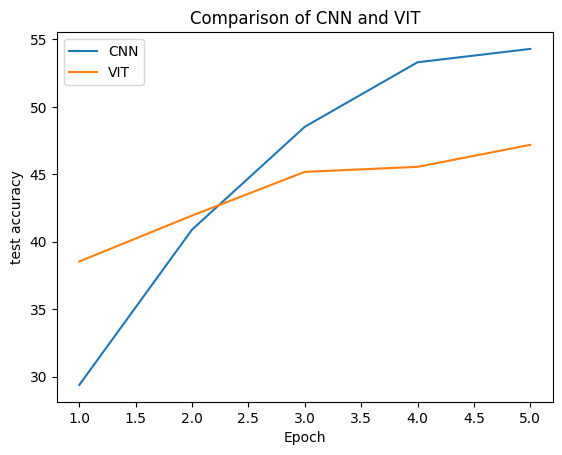

In [18]:
plt.plot(list(range(1,6)), CNNLossList, label='CNN')
plt.plot(list(range(1,6)), VITlossList[:5], label='VIT')

# Labeling the axes
plt.xlabel('Epoch')
plt.ylabel('test accuracy')

# Title
plt.title('Comparison of CNN and VIT')

# Displaying legend
plt.legend()

# Display the plot
plt.show()

After 2 epochs, Convolutional Neural Networks (CNNs) consistently demonstrate superior accuracy compared to Vision Transformers (ViTs) in image classification tasks.

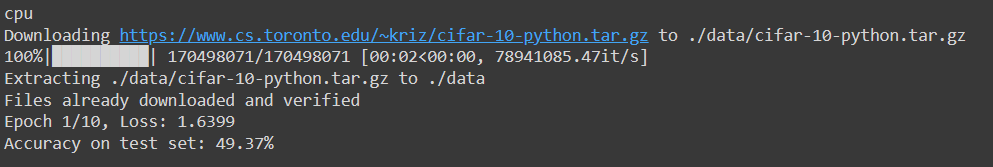

Given the above image is used in question (Q2) with parameters L = 6 and hiddenLayerSizeFFN = 128, it requires approximately 30-40 minutes to complete one epoch due to resource limitations.